## Imports

In [1]:
%matplotlib inline
from time import time
import numpy as np
from sklearn import model_selection
from sklearn import svm
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, space_eval
import scipy.stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
plt.style.use(['dark_background'])

## Functions

In [3]:
def objective_hyperopt(params, k_folds=10):
    kf = model_selection.KFold(n_splits=k_folds)
    objective_val = 0
    for train_index, test_index in kf.split(X):
        x_train, x_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        model = svm.SVR(kernel='rbf', C=params['C'], gamma=params['gamma'])
        model.fit(x_train, y_train)
        accuracy = model.score(x_test, y_test)
        objective_val += 1 - accuracy  # objective = the error
    return objective_val


def param_space_hyperopt(c1, c2, g1, g2):
    params = {
        'C': hp.uniform("C", c1, c2),
        'gamma': hp.uniform("gamma", g1, g2),
    }
    return params

## Generate data:

In [4]:

np.random.seed(1)
n_data_points = 50
X = np.sort(5 * np.random.rand(n_data_points, 1), axis=0)
# Noise-free data:
y0 = np.sin(X).ravel()  
# Noisy data:
noise_scale = 0.5
y = y0 + np.random.uniform(-noise_scale, noise_scale, n_data_points)

In [5]:
# Range of parameter values:
C_min, C_max = 0, 5000
gamma_min, gamma_max = 0, 0.5

In [6]:
# --- Default model:
model_default = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
model_default.fit(X, y)
y_default = model_default.predict(X)

In [7]:
# --- Random search:
kfolds, iterations = 10, 20
scorer = make_scorer(mean_squared_error, greater_is_better=False)
scale_C, scale_gamma = C_max - C_min, gamma_max - gamma_min
# Initialize model:
model_rnd = svm.SVR(kernel='rbf')
# Parameter distributions:
param_dist = {'C': scipy.stats.uniform(loc=C_min, scale=scale_C), 'gamma': scipy.stats.uniform(loc=gamma_min, scale=scale_gamma)}
rand_search = RandomizedSearchCV(model_rnd, param_distributions=param_dist, n_iter=iterations, cv=kfolds, return_train_score=True, scoring=scorer)
start = time()
rand_search.fit(X, y)
stop = time()
rs_best_results_dict = rand_search.best_params_
best_score = rand_search.best_score_
# Use best parameter values:
final_model_rand = svm.SVR(kernel='rbf', C=rs_best_results_dict['C'], gamma=rs_best_results_dict['gamma'])
final_model_rand.fit(X, y)
y_rand = final_model_rand.predict(X)

In [8]:
# --- Hyperopt:
parameters = param_space_hyperopt(C_min, C_max, gamma_min, gamma_max)
start = time()
best = fmin(fn=objective_hyperopt, space=parameters, algo=tpe.suggest, max_evals=iterations)
hyperopt_results_dict = space_eval(parameters, best)
stop = time()
model_hyp = svm.SVR(kernel='rbf', C=hyperopt_results_dict['C'], gamma=hyperopt_results_dict['gamma'])
model_hyp.fit(X, y)
y_hyp = model_hyp.predict(X)

In [9]:
# --- Summary:
print("Random Search took %.2f seconds for %d candidate parameter settings." % ((stop - start), iterations))
print("HyperOpt took %.2f seconds for %d candidate parameter settings." % ((stop - start), iterations))
print('Random Search best = ', rs_best_results_dict)
print('HyperOpt best = ', hyperopt_results_dict)
print('score (Default) = %2.3f, MSE = %.4f' % (model_default.score(X, y), mean_squared_error(y0, y_default)))
print('score (Random) = %2.3f, MSE = %.4f' % (final_model_rand.score(X, y), mean_squared_error(y0, y_rand)))
print('score (HyperOpt) = %2.3f, MSE = %.4f' % (model_hyp.score(X, y), mean_squared_error(y0, y_hyp)))

Random Search took 1.07 seconds for 20 candidate parameter settings.
HyperOpt took 1.07 seconds for 20 candidate parameter settings.
Random Search best =  {'C': 1042.8415582710704, 'gamma': 0.024652122376578878}
HyperOpt best =  {'C': 3802.418281673273, 'gamma': 0.0426725489742254}
score (Default) = 0.880, MSE = 0.0147
score (Random) = 0.880, MSE = 0.0147
score (HyperOpt) = 0.880, MSE = 0.0114


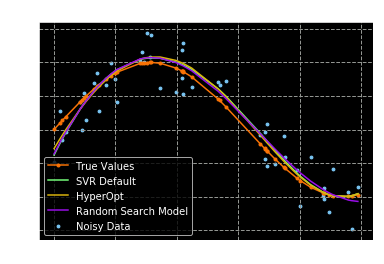

In [11]:
# --- Plot:
mkr_size = 3
plt.scatter(X, y, color='xkcd:lightblue', marker='o', s=8, label='Noisy Data')
plt.plot(X, y0, color='xkcd:orange', linestyle='-', marker='o', markersize=mkr_size, label='True Values')
plt.plot(X, y_default, color='xkcd:lightgreen', markersize=mkr_size, label='SVR Default')
plt.plot(X, y_hyp, color='xkcd:gold', linestyle='-', label='HyperOpt')
plt.plot(X, y_rand, color='xkcd:violet', linestyle='-', label='Random Search Model')
plt.legend()
plt.grid()
plt.title('Comparison between HyperOpt and Randomized Search')
plt.tick_params(axis='both', grid_alpha=1, grid_color='xkcd:grey', grid_linestyle='--', grid_linewidth=1)